To Build a :
- Network with Group Normalization
- Network with Layer Normalization
- Network with L1 + BN
- Network with L2 + BN


## Importing Libraries

In [ ]:
# import model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np 

## Downloading DataSet


In [ ]:
torch.manual_seed(1)
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
bs = 256

train_set = torch.utils.data.DataLoader(
    datasets.MNIST('../data/', train=True, download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
    ),
    batch_size=bs, shuffle=True, **kwargs
)

test_set = torch.utils.data.DataLoader(
    datasets.MNIST('../data/', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
    ),
    batch_size=bs, **kwargs
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Defining the model


In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, drop=0.05, norm='gn' , groups=4):
    
    super(Net, self).__init__()
    self.max_pool = nn.MaxPool2d(2,2)
    def Normalize(x):
      if norm == 'bn':
        return nn.BatchNorm2d(x)
      elif norm =='ln':
        return nn.GroupNorm(1,x)
      elif norm =='gn':
        return nn.GroupNorm(groups,x)
      else:
        return None

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(1, 8, 3, padding=1, bias=False),
        Normalize(8),
        nn.ReLU(),
        nn.Dropout2d(drop),

        nn.Conv2d(8, 24, 3, padding=1, bias=False),
        Normalize(24),
        nn.ReLU(),
        nn.Dropout2d(drop),

       
    )

    self.transition1 = nn.Sequential(
        nn.Conv2d(24, 8, 1, bias=False),
        Normalize(8),
        nn.ReLU(),
        nn.Dropout2d(drop),
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(8, 16, 3, bias=False),
        Normalize(16),
        nn.ReLU(),
        nn.Dropout2d(drop),
 nn.Conv2d(16, 24, 3, bias=False),
        Normalize(24),
        nn.ReLU(),
        nn.Dropout2d(drop),
    )

    self.transition2 = nn.Sequential(
        nn.Conv2d(24, 8, 1, bias=False),
        Normalize(8),
        nn.ReLU(),
        nn.Dropout2d(drop),
    )
  
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(8, 16, 3, bias=False),
        Normalize(16),
        nn.ReLU(),
        nn.Dropout2d(drop),

        nn.Conv2d(16, 32, 3, bias=False),
        Normalize(32),
        nn.ReLU(),
        nn.Dropout2d(drop),
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(6)
    )
    self.dense = nn.Linear(32, 10)

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.max_pool(x)
    x = self.transition1(x)

    x = self.conv_block2(x)
    x = self.transition2(x)

    x = self.conv_block3(x)

    x = self.gap(x)
    x = x.view(-1, 32)    
    x = self.dense(x)

    return F.log_softmax(x, dim=1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = Net().to(device)
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
         GroupNorm-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 24, 28, 28]           1,728
         GroupNorm-6           [-1, 24, 28, 28]              48
              ReLU-7           [-1, 24, 28, 28]               0
         Dropout2d-8           [-1, 24, 28, 28]               0
         MaxPool2d-9           [-1, 24, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             192
        GroupNorm-11            [-1, 8, 14, 14]              16
             ReLU-12            [-1, 8, 14, 14]               0
        Dropout2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Training the network


In [ ]:
def train(model, device, train_loader, optimizer, use_l1, lambda_l1):
    model.train() # training model
    pbar = tqdm(train_loader)
    t_acc = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # optimizer
        output = model(data) # output of the model

        loss = F.nll_loss(output, target) # calculate the loss
        l1 = 0
        if use_l1:
          for p in model.parameters():
            l1 = l1+ p.abs().sum()
        loss = loss+ lambda_l1*l1
        loss.backward() # backpropogation
        optimizer.step() # optimization

        pred = output.argmax(dim=1).eq(target).sum().item() # final prediction
        t_acc += pred # accuracy
        pbar.set_description(desc= f'loss={loss.item():.4f} batch_id={batch_idx}') # setting the output
    
    return loss.item(), t_acc / len(train_loader.dataset)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) # output of the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # printing the loss and accuracy of test
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct/len(test_loader.dataset)

In [ ]:
def fit(net, lr ,num_epoch, use_l1, use_l2=False, lambda_l1=0.05):
  if use_l2:
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4) # SGD optimizer
  else:
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

  # defining the dictionary for train and test, loss and accuracy
  h = dict() 
  h['train_loss'] = list()
  h['train_accuracy'] = list()
  h['test_loss'] = list()
  h['test_accuracy'] = list()

  for epoch in range(1, num_epoch+1):
      print(epoch)
      train_loss, train_acc = train(net, device, train_set, optimizer, use_l1, lambda_l1) # calling the training
      test_loss, test_acc = test(net, device, test_set) # calling the testing

      h['train_loss'].append(train_loss) # storing the training loss
      h['train_accuracy'].append(train_acc) # storing  the accuracy

      h['test_loss'].append(test_loss) # storing the testing loss
      h['test_accuracy'].append(test_acc) # storing the testing accuracy
  return net, h

### Batch Normalisation

In [ ]:
net_bn, hist_bn = fit(Net(norm='bn').to(device), lr=0.01, num_epoch=20, use_l1=False, use_l2=False)

1


loss=0.5185 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.02it/s]


Test set: Average loss: 0.3092, Accuracy: 9528/10000 (95.28%)

2


loss=0.1884 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.24it/s]


Test set: Average loss: 0.1144, Accuracy: 9748/10000 (97.48%)

3


loss=0.1935 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.14it/s]


Test set: Average loss: 0.0800, Accuracy: 9799/10000 (97.99%)

4


loss=0.1227 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.18it/s]


Test set: Average loss: 0.0609, Accuracy: 9841/10000 (98.41%)

5


loss=0.1256 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.20it/s]


Test set: Average loss: 0.0537, Accuracy: 9837/10000 (98.37%)

6


loss=0.1058 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.08it/s]


Test set: Average loss: 0.0448, Accuracy: 9870/10000 (98.70%)

7


loss=0.0508 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.10it/s]


Test set: Average loss: 0.0415, Accuracy: 9871/10000 (98.71%)

8


loss=0.1214 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.06it/s]


Test set: Average loss: 0.0373, Accuracy: 9886/10000 (98.86%)

9


loss=0.1074 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.03it/s]


Test set: Average loss: 0.0357, Accuracy: 9890/10000 (98.90%)

10


loss=0.0825 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.12it/s]


Test set: Average loss: 0.0315, Accuracy: 9903/10000 (99.03%)

11


loss=0.1791 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.90it/s]


Test set: Average loss: 0.0305, Accuracy: 9904/10000 (99.04%)

12


loss=0.1026 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.02it/s]


Test set: Average loss: 0.0327, Accuracy: 9897/10000 (98.97%)

13


loss=0.0483 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.87it/s]


Test set: Average loss: 0.0302, Accuracy: 9907/10000 (99.07%)

14


loss=0.1111 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.94it/s]


Test set: Average loss: 0.0290, Accuracy: 9903/10000 (99.03%)

15


loss=0.0782 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.95it/s]


Test set: Average loss: 0.0297, Accuracy: 9899/10000 (98.99%)

16


loss=0.1786 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.92it/s]


Test set: Average loss: 0.0274, Accuracy: 9914/10000 (99.14%)

17


loss=0.0240 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.84it/s]


Test set: Average loss: 0.0277, Accuracy: 9909/10000 (99.09%)

18


loss=0.0325 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.97it/s]


Test set: Average loss: 0.0259, Accuracy: 9919/10000 (99.19%)

19


loss=0.0618 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.00it/s]


Test set: Average loss: 0.0289, Accuracy: 9901/10000 (99.01%)

20


loss=0.0415 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.86it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)



### Group Normalisation

In [ ]:
net_gn, hist_gn = fit(Net(norm='gn').to(device), lr=0.01, num_epoch=20, use_l1=False, use_l2=False)

1


loss=0.6128 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.88it/s]


Test set: Average loss: 0.4505, Accuracy: 9077/10000 (90.77%)

2


loss=0.2273 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.64it/s]


Test set: Average loss: 0.1363, Accuracy: 9672/10000 (96.72%)

3


loss=0.3145 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.78it/s]


Test set: Average loss: 0.0781, Accuracy: 9786/10000 (97.86%)

4


loss=0.1267 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.91it/s]


Test set: Average loss: 0.0658, Accuracy: 9811/10000 (98.11%)

5


loss=0.0955 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.77it/s]


Test set: Average loss: 0.0490, Accuracy: 9861/10000 (98.61%)

6


loss=0.1479 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.81it/s]


Test set: Average loss: 0.0472, Accuracy: 9859/10000 (98.59%)

7


loss=0.1631 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.80it/s]


Test set: Average loss: 0.0409, Accuracy: 9874/10000 (98.74%)

8


loss=0.1491 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.79it/s]


Test set: Average loss: 0.0368, Accuracy: 9895/10000 (98.95%)

9


loss=0.0607 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.79it/s]


Test set: Average loss: 0.0340, Accuracy: 9900/10000 (99.00%)

10


loss=0.0531 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.90it/s]


Test set: Average loss: 0.0352, Accuracy: 9894/10000 (98.94%)

11


loss=0.1828 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.77it/s]


Test set: Average loss: 0.0323, Accuracy: 9900/10000 (99.00%)

12


loss=0.0486 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.68it/s]


Test set: Average loss: 0.0309, Accuracy: 9914/10000 (99.14%)

13


loss=0.0340 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.87it/s]


Test set: Average loss: 0.0296, Accuracy: 9914/10000 (99.14%)

14


loss=0.0845 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.82it/s]


Test set: Average loss: 0.0288, Accuracy: 9913/10000 (99.13%)

15


loss=0.1089 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.78it/s]


Test set: Average loss: 0.0290, Accuracy: 9913/10000 (99.13%)

16


loss=0.0699 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.84it/s]


Test set: Average loss: 0.0258, Accuracy: 9929/10000 (99.29%)

17


loss=0.0824 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.80it/s]


Test set: Average loss: 0.0254, Accuracy: 9929/10000 (99.29%)

18


loss=0.0728 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.86it/s]


Test set: Average loss: 0.0271, Accuracy: 9917/10000 (99.17%)

19


loss=0.1002 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.76it/s]


Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.28%)

20


loss=0.0147 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.73it/s]


Test set: Average loss: 0.0259, Accuracy: 9927/10000 (99.27%)



### Layer Normalisation

In [ ]:
net_ln, hist_ln = fit(Net(norm='ln').to(device), lr=0.01, num_epoch=20, use_l1=False, use_l2=False)

1


loss=0.8139 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.85it/s]


Test set: Average loss: 0.4481, Accuracy: 9056/10000 (90.56%)

2


loss=0.3278 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.94it/s]


Test set: Average loss: 0.1758, Accuracy: 9583/10000 (95.83%)

3


loss=0.2933 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.87it/s]


Test set: Average loss: 0.1289, Accuracy: 9643/10000 (96.43%)

4


loss=0.1714 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.75it/s]


Test set: Average loss: 0.0876, Accuracy: 9768/10000 (97.68%)

5


loss=0.1055 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.92it/s]


Test set: Average loss: 0.0747, Accuracy: 9782/10000 (97.82%)

6


loss=0.0806 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.91it/s]


Test set: Average loss: 0.0628, Accuracy: 9817/10000 (98.17%)

7


loss=0.1617 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.86it/s]


Test set: Average loss: 0.0507, Accuracy: 9847/10000 (98.47%)

8


loss=0.0751 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.82it/s]


Test set: Average loss: 0.0480, Accuracy: 9853/10000 (98.53%)

9


loss=0.0697 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.85it/s]


Test set: Average loss: 0.0449, Accuracy: 9864/10000 (98.64%)

10


loss=0.0523 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.82it/s]


Test set: Average loss: 0.0408, Accuracy: 9873/10000 (98.73%)

11


loss=0.0497 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.83it/s]


Test set: Average loss: 0.0378, Accuracy: 9889/10000 (98.89%)

12


loss=0.0702 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.87it/s]


Test set: Average loss: 0.0367, Accuracy: 9894/10000 (98.94%)

13


loss=0.1081 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.87it/s]


Test set: Average loss: 0.0413, Accuracy: 9871/10000 (98.71%)

14


loss=0.1132 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.86it/s]


Test set: Average loss: 0.0415, Accuracy: 9871/10000 (98.71%)

15


loss=0.0581 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.92it/s]


Test set: Average loss: 0.0367, Accuracy: 9888/10000 (98.88%)

16


loss=0.0612 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.88it/s]


Test set: Average loss: 0.0317, Accuracy: 9897/10000 (98.97%)

17


loss=0.0496 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.76it/s]


Test set: Average loss: 0.0301, Accuracy: 9903/10000 (99.03%)

18


loss=0.0290 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.69it/s]


Test set: Average loss: 0.0332, Accuracy: 9898/10000 (98.98%)

19


loss=0.0879 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.73it/s]


Test set: Average loss: 0.0300, Accuracy: 9903/10000 (99.03%)

20


loss=0.0363 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.93it/s]


Test set: Average loss: 0.0284, Accuracy: 9916/10000 (99.16%)



### Batch Normalisation and L1

In [ ]:
net_ln, hist_l1 = fit(Net(norm='bn').to(device), lr=0.01, num_epoch=20, use_l1=True, use_l2=False)

1


loss=2.8210 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.02it/s]


Test set: Average loss: 2.3025, Accuracy: 1135/10000 (11.35%)

2


loss=2.6773 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.71it/s]


Test set: Average loss: 2.3026, Accuracy: 982/10000 (9.82%)

3


loss=2.6760 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.72it/s]


Test set: Average loss: 2.3026, Accuracy: 974/10000 (9.74%)

4


loss=2.6809 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.68it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

5


loss=2.6763 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.77it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

6


loss=2.6770 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.98it/s]


Test set: Average loss: 2.3025, Accuracy: 1135/10000 (11.35%)

7


loss=2.6757 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.15it/s]


Test set: Average loss: 2.3026, Accuracy: 1135/10000 (11.35%)

8


loss=2.6793 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.84it/s]


Test set: Average loss: 2.3026, Accuracy: 982/10000 (9.82%)

9


loss=2.6781 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.87it/s]


Test set: Average loss: 2.3026, Accuracy: 982/10000 (9.82%)

10


loss=2.6762 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.69it/s]


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10.28%)

11


loss=2.6800 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.83it/s]


Test set: Average loss: 2.3026, Accuracy: 1010/10000 (10.10%)

12


loss=2.6790 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.58it/s]


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10.28%)

13


loss=2.6782 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.83it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

14


loss=2.6791 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.00it/s]


Test set: Average loss: 2.3026, Accuracy: 974/10000 (9.74%)

15


loss=2.6795 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.91it/s]


Test set: Average loss: 2.3026, Accuracy: 1032/10000 (10.32%)

16


loss=2.6807 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.76it/s]


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10.28%)

17


loss=2.6842 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.81it/s]


Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

18


loss=2.6778 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.62it/s]


Test set: Average loss: 2.3026, Accuracy: 974/10000 (9.74%)

19


loss=2.6794 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.80it/s]


Test set: Average loss: 2.3026, Accuracy: 974/10000 (9.74%)

20


loss=2.6772 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.57it/s]


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10.28%)



### Batch Normalisation and L2

In [ ]:
net_ln, hist_l2 = fit(Net(norm='bn').to(device), lr=0.01, num_epoch=20, use_l1=False, use_l2=True)

1


loss=0.5585 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.90it/s]


Test set: Average loss: 0.3558, Accuracy: 9522/10000 (95.22%)

2


loss=0.1782 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.97it/s]


Test set: Average loss: 0.1397, Accuracy: 9717/10000 (97.17%)

3


loss=0.1649 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.01it/s]


Test set: Average loss: 0.0757, Accuracy: 9818/10000 (98.18%)

4


loss=0.1927 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.85it/s]


Test set: Average loss: 0.0555, Accuracy: 9854/10000 (98.54%)

5


loss=0.1513 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.92it/s]


Test set: Average loss: 0.0524, Accuracy: 9869/10000 (98.69%)

6


loss=0.2146 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.98it/s]


Test set: Average loss: 0.0440, Accuracy: 9879/10000 (98.79%)

7


loss=0.1175 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.91it/s]


Test set: Average loss: 0.0407, Accuracy: 9887/10000 (98.87%)

8


loss=0.0955 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.03it/s]


Test set: Average loss: 0.0371, Accuracy: 9891/10000 (98.91%)

9


loss=0.0830 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.98it/s]


Test set: Average loss: 0.0365, Accuracy: 9898/10000 (98.98%)

10


loss=0.0485 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.84it/s]


Test set: Average loss: 0.0331, Accuracy: 9898/10000 (98.98%)

11


loss=0.0620 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.87it/s]


Test set: Average loss: 0.0344, Accuracy: 9887/10000 (98.87%)

12


loss=0.0520 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.97it/s]


Test set: Average loss: 0.0318, Accuracy: 9909/10000 (99.09%)

13


loss=0.0478 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.86it/s]


Test set: Average loss: 0.0317, Accuracy: 9903/10000 (99.03%)

14


loss=0.1263 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.08it/s]


Test set: Average loss: 0.0272, Accuracy: 9914/10000 (99.14%)

15


loss=0.1657 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.76it/s]


Test set: Average loss: 0.0291, Accuracy: 9914/10000 (99.14%)

16


loss=0.0388 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.80it/s]


Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)

17


loss=0.1016 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.03it/s]


Test set: Average loss: 0.0276, Accuracy: 9919/10000 (99.19%)

18


loss=0.0554 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.82it/s]


Test set: Average loss: 0.0271, Accuracy: 9916/10000 (99.16%)

19


loss=0.0687 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.85it/s]


Test set: Average loss: 0.0290, Accuracy: 9911/10000 (99.11%)

20


loss=0.0722 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.87it/s]


Test set: Average loss: 0.0271, Accuracy: 9912/10000 (99.12%)



## Plotting the Loss curve and Accuracy for different EPOCHS



In [ ]:
def plot_history(h, norm):
  # Ploting the graphs for loss and accuracy 
  # For loss and epochs
  plt.figure(figsize=(14,5))
  plt.title(norm)
  
  plt.subplot(1,2,1)
  plt.plot(h['train_loss'], label='Training Loss') # plotting the training loss
  plt.plot(h['test_loss'], label='Test Loss') # plotting the testing loss
  # putting the labels on plot
  plt.title('Loss vs Epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

  # For accuracy and epochs
  plt.subplot(1,2,2)
  plt.plot(h['train_accuracy'], label='Training Accuracy') # plotting the training accuracy
  plt.plot(h['test_accuracy'], label='Test Accuracy') # plotting the testing accuracy
  # putting the labels in plot
  plt.title('Accuracy vs Epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()

  plt.show()

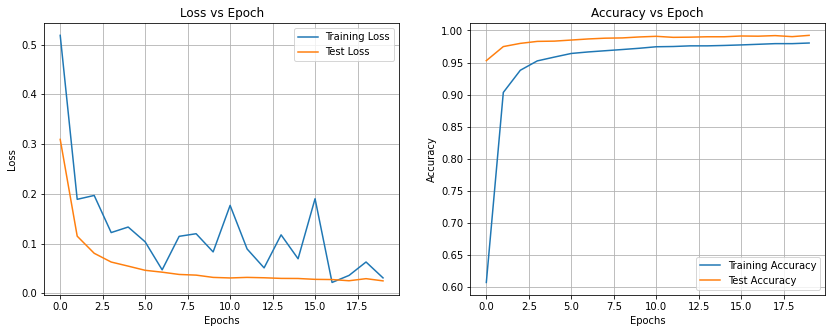

In [ ]:
# Plot for Batch Normalisation
plot_history(hist_bn, norm = 'bn')

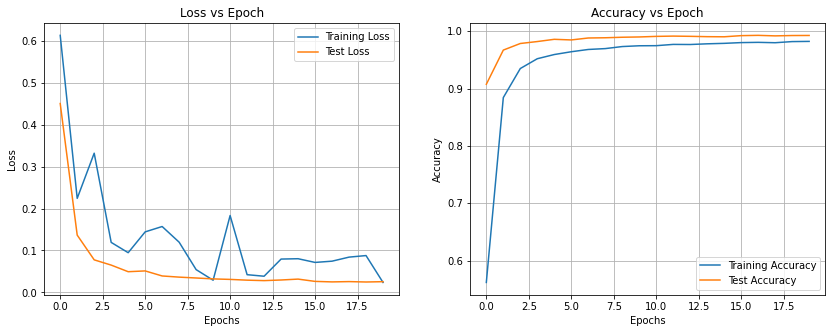

In [ ]:
# Plot for Group Normalisation
plot_history(hist_gn, norm = 'gn')

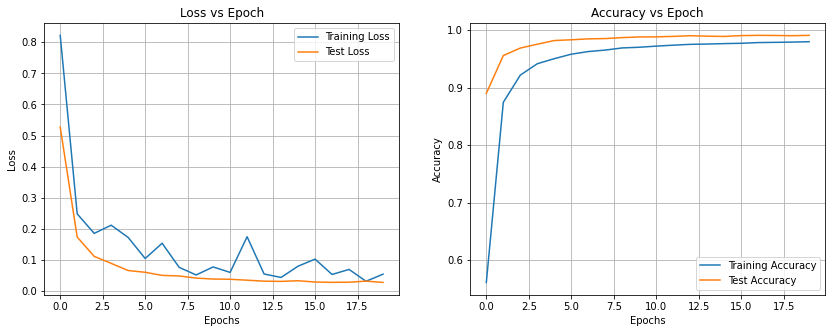

In [ ]:
# Plot for Layer Normalisation
plot_history(hist_ln, norm = 'ln')

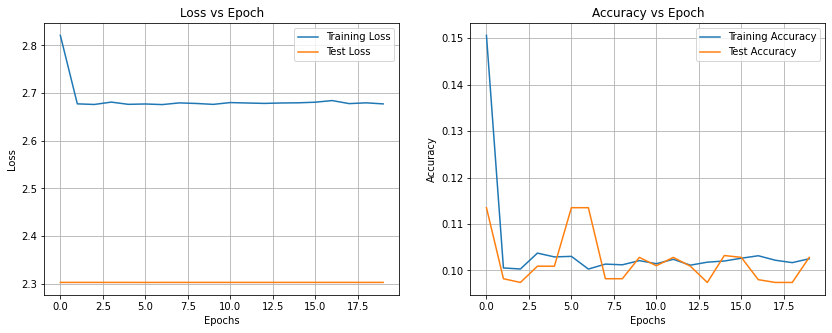

In [ ]:
# Plot for Batch Normalisation + L1
plot_history(hist_l1, norm = 'bn')

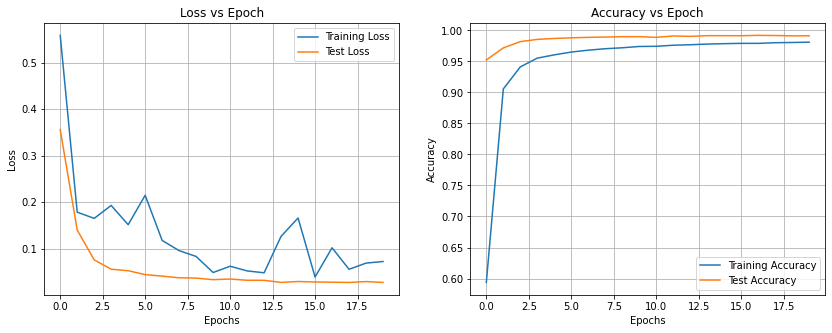

In [ ]:
# Plot for Batch Normalisation + L2
plot_history(hist_l2, norm = 'bn')

In [ ]:
### Visualising the misclassified Data while using Batch Normalisation

In [ ]:
def plot_misclassified(net, data_loader, plot_title, num_images=20, row=4, col=5):
  count = 0
  k = 0
  row, col = row, col
  fig = plt.figure(figsize=(col*2, row*3))
  while count<num_images:
    img, label = data_loader.dataset[k]
    pred = net(img.unsqueeze(0).to(device)).argmax().item()

    if pred!=label:
      count+=1
      fig.add_subplot(row, col, count)
      plt.suptitle(plot_title)
      plt.title(f"Ground Truth :{label}\n Prediction: {pred}")
      plt.imshow(img.squeeze(0), cmap='gray')
      plt.axis('off')
    k += 1
  plt.tight_layout()
  plt.show()


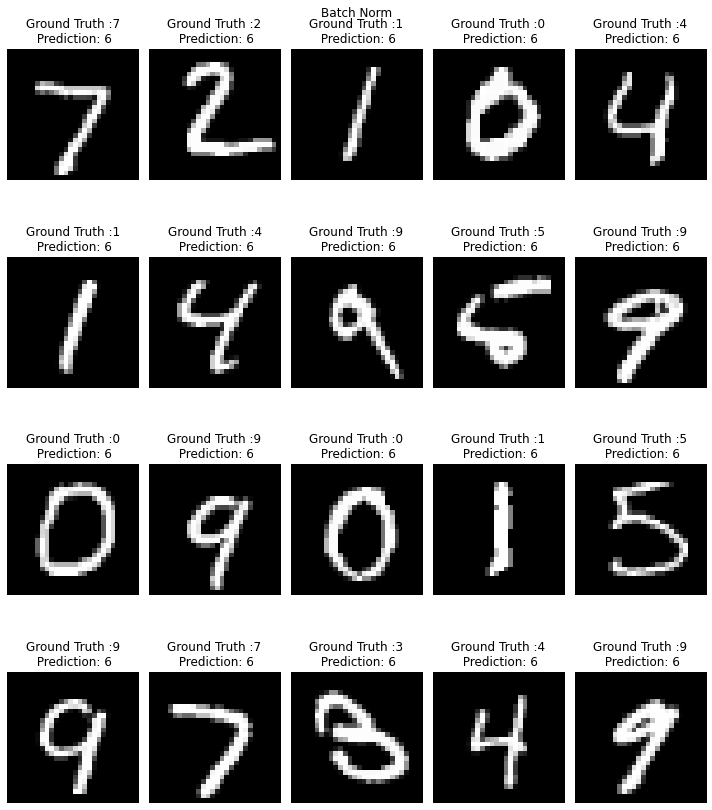

In [ ]:
plot_misclassified(Net(norm='bn').to(device), test_set, plot_title='Batch Norm')

In [ ]:
### Visualising the classified Data while using Batch Normalisation

In [ ]:
def plot_classified(net, data_loader, plot_title, num_images=20, row=4, col=5):
  count = 0
  k = 0
  row, col = row, col
  fig = plt.figure(figsize=(col*2, row*3))
  while count<num_images:
    img, label = data_loader.dataset[k]
    pred = net(img.unsqueeze(0).to(device)).argmax().item()

    if pred ==label:
      count+=1
      fig.add_subplot(row, col, count)
      plt.suptitle(plot_title)
      plt.title(f"Ground Truth :{label}\n Prediction: {pred}")
      plt.imshow(img.squeeze(0), cmap='gray')
      plt.axis('off')
    k += 1
  plt.tight_layout()
  plt.show()

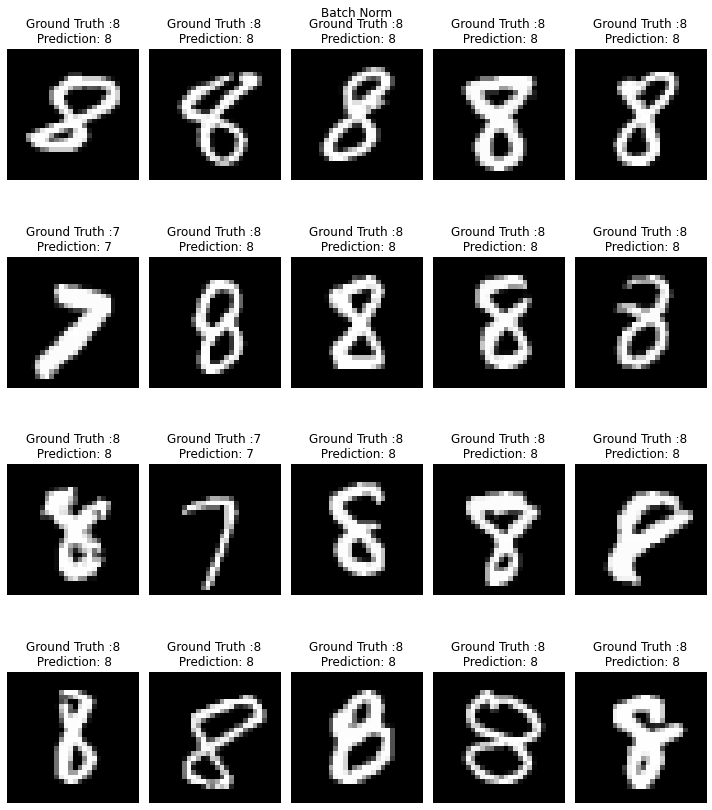

In [ ]:
plot_classified(Net(norm='bn').to(device), test_set, plot_title='Batch Norm')